# Práctica 7 - SIFT

## Preparación

Para correr este Jupyter Notebook es necesario tener instalado Python 3, y los paquetes de opencv y opencv-contrib:

```bash
pip install --user opencv-python==3.4.2.16
pip install --user opencv-contrib-python==3.4.2.16
```
SIFT está implementado en opencv-contrib, pero éste requiere esa versión de opencv (instalada desde pip). Es recomendable usar virtualenv para asegurarse que se tienen exactamente estas versiones instaladas cuando se ejecute este notebook.

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def imshow(img, ax=None):
    opts = dict(interpolation='bicubic')
    # If image is grayscale, use proper color map
    if len(img.shape) == 2 or img.shape[2] == 1:
        opts['cmap'] = 'gray'
    if ax:
        ax.imshow(img, **opts)
    else:
        plt.figure(figsize=(8, 8))
        plt.imshow(img, **opts)

## Detección de puntos característicos (*keypoints*)

In [3]:
img = cv2.imread('img/macheo1.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

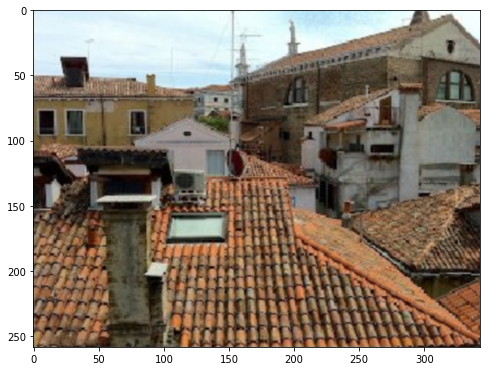

In [4]:
imshow(img)

In [5]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

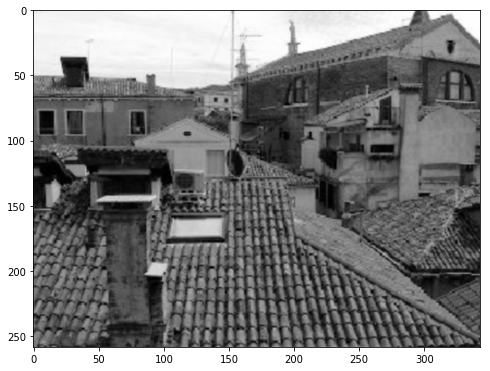

In [6]:
imshow(gray)

In [7]:
sift = cv2.xfeatures2d.SIFT_create()
kps = sift.detect(gray, None)
len(kps)

1295

In [8]:
img_desc = cv2.drawKeypoints(gray, kps, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

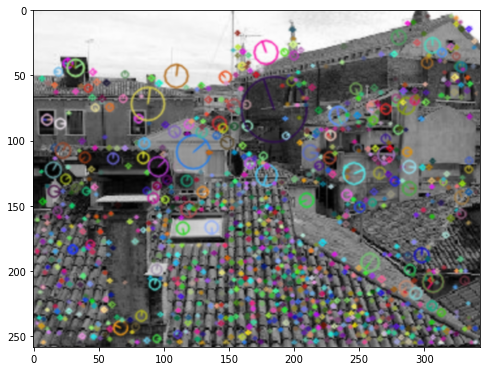

In [9]:
imshow(img_desc)

## Transformaciones a la imagen

In [10]:
def plot_multiple(images, rows=2, cols=6):
    plt.figure(figsize=(16, 4))
    img_range = np.linspace(0, len(images), num=rows*cols, endpoint=False, dtype=np.uint8)
    for i, j in enumerate(img_range):
        ax = plt.subplot(rows, cols, i + 1, frameon=False)
        imshow(images[j], ax=ax)

### Rotaciones

Generamos una secuencia de 360 imágenes rotadas alrededor del centro en pasos de 1 grado.

In [11]:
def rotate(image, angle, center=None, scale=1.0):
    h, w = image.shape[:2]

    # If the center is None,
    # initialize it as the center of the image.
    if center is None:
        center = (w // 2, h // 2)

    M = cv2.getRotationMatrix2D(center, angle, scale)
    rotated = cv2.warpAffine(image, M, (w, h))

    return rotated

In [12]:
rotated_images = [rotate(img, angle) for angle in range(360)]

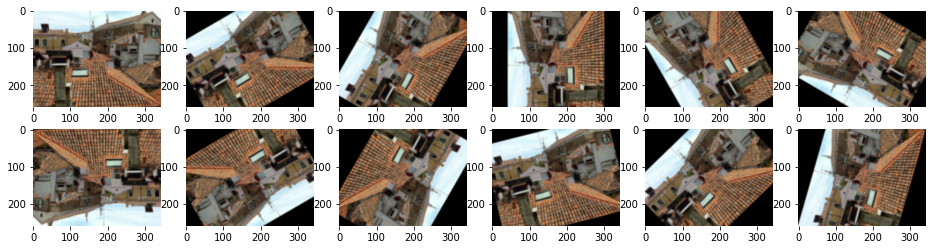

In [13]:
plot_multiple(rotated_images)

### Reescalar

Generamos una secuencia de 175 imágenes reescaladas

In [14]:
def scale(img, ratio=2, interpolation=cv2.INTER_CUBIC):
    return cv2.resize(img, None, fx=ratio, fy=ratio, interpolation=interpolation)

In [15]:
s_range = np.arange(0.25, 2.0, 0.01)

In [16]:
len(s_range)

175

In [17]:
scaled_images = [scale(img, s) for s in s_range]

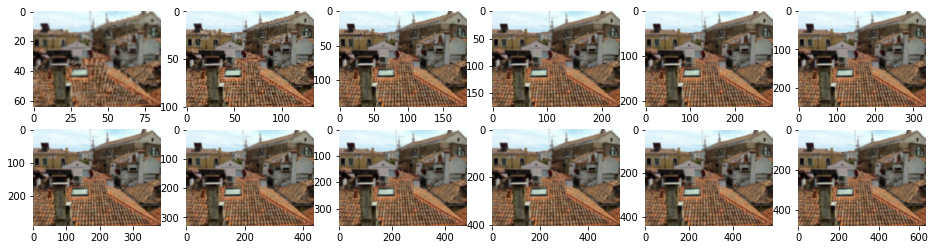

In [18]:
plot_multiple(scaled_images)

### Brillo

In [19]:
def adjust_brightness(img, value=0):
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    h, s, v = cv2.split(hsv)
    v = v.astype(dtype=np.uint16)
    v = np.clip(v + value, 0, 255).astype(np.uint8)
    new_hsv = cv2.merge((h, s, v))
    return cv2.cvtColor(new_hsv, cv2.COLOR_HSV2RGB)

In [20]:
b_range = range(-127, 128)
len(b_range)

255

In [21]:
brightened_images = [adjust_brightness(img, value=v) for v in b_range]

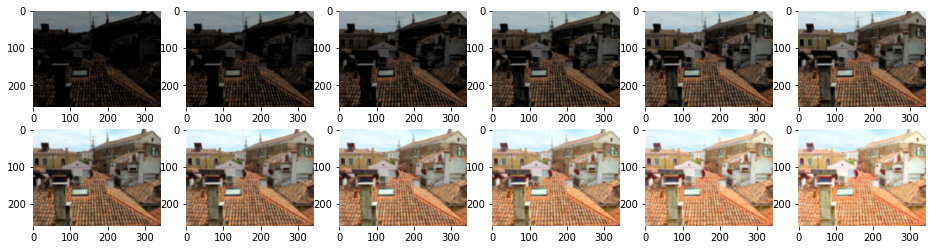

In [22]:
plot_multiple(brightened_images)

### Ruido Gaussiano

In [23]:
from skimage import img_as_float
from skimage.util import random_noise

In [24]:
v_range = np.arange(3, 42, 2) / 200
v_range

array([0.015, 0.025, 0.035, 0.045, 0.055, 0.065, 0.075, 0.085, 0.095,
       0.105, 0.115, 0.125, 0.135, 0.145, 0.155, 0.165, 0.175, 0.185,
       0.195, 0.205])

In [25]:
len(v_range)

20

In [26]:
def rescale_image(img):
    return (img * 255).astype(np.uint8)

In [27]:
noised_images = [rescale_image(random_noise(img, mode='gaussian', clip=True, seed=1773, var=v)) for v in v_range]

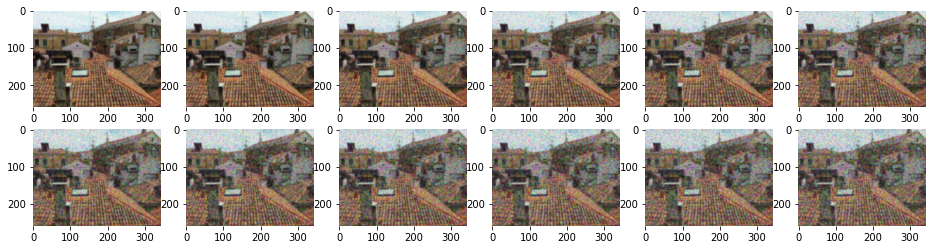

In [28]:
plot_multiple(noised_images)

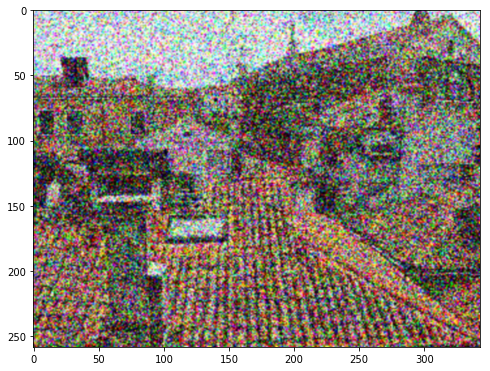

In [29]:
imshow(noised_images[19])

## SIFT para detección de keypoints

In [30]:
def sift_keypoints(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    sift = cv2.xfeatures2d.SIFT_create(nfeatures=100)
    kps = sift.detect(gray, None)
    return kps

In [31]:
%%time
rotated_kps = [sift_keypoints(k) for k in rotated_images]

CPU times: user 20.1 s, sys: 2.45 s, total: 22.5 s
Wall time: 9.34 s


In [32]:
%%time
scaled_kps = [sift_keypoints(k) for k in scaled_images]

CPU times: user 13.7 s, sys: 1.85 s, total: 15.5 s
Wall time: 6.14 s


In [33]:
%%time
brightened_kps = [sift_keypoints(k) for k in brightened_images]

CPU times: user 13.9 s, sys: 478 ms, total: 14.4 s
Wall time: 5.45 s


In [34]:
%%time
noised_kps = [sift_keypoints(k) for k in noised_images]

CPU times: user 1.12 s, sys: 29 ms, total: 1.15 s
Wall time: 438 ms


## RANSAC para remover outliers

In [35]:
from sklearn.linear_model import RANSACRegressor

In [36]:
sift = cv2.xfeatures2d.SIFT_create()
kps, descs = sift.detectAndCompute(gray, None)

In [37]:
X = np.array([kp.pt[0] for kp in kps]).reshape(-1, 1)
y = np.array([kp.pt[1] for kp in kps])
X.shape, y.shape

((1295, 1), (1295,))

In [38]:
X.reshape(-1, 1).shape

(1295, 1)

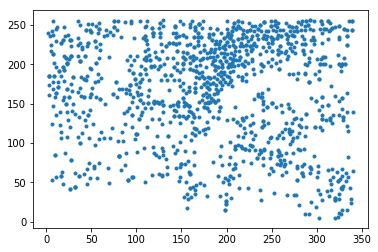

In [39]:
plt.scatter(X, y, marker='.')

In [41]:
ransac = RANSACRegressor(residual_threshold=5, stop_n_inliers=10, random_state=1337)
ransac.fit(X, y)

RANSACRegressor(base_estimator=None, is_data_valid=None, is_model_valid=None,
        loss='absolute_loss', max_skips=inf, max_trials=100,
        min_samples=None, random_state=1337, residual_threshold=5,
        stop_n_inliers=10, stop_probability=0.99, stop_score=inf)

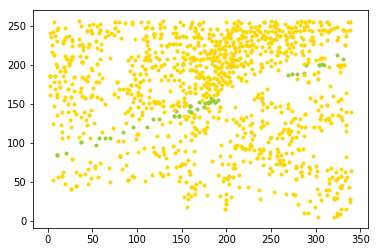

In [42]:
inlier_mask = ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)

plt.scatter(X[inlier_mask], y[inlier_mask], color='yellowgreen', marker='.',
            label='Inliers')
plt.scatter(X[outlier_mask], y[outlier_mask], color='gold', marker='.',
            label='Outliers')

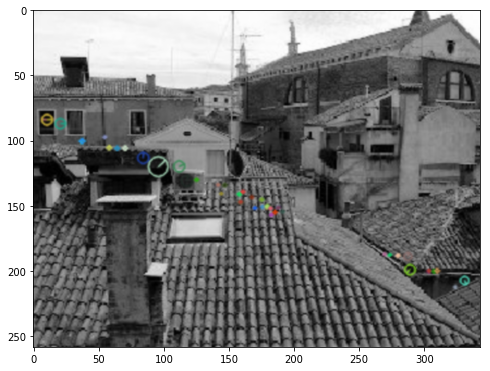

In [43]:
new_kps = np.array(kps)[inlier_mask]
img_desc = cv2.drawKeypoints(gray, new_kps, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
imshow(img_desc)

In [44]:
sift = cv2.xfeatures2d.SIFT_create(nfeatures=100)
kps = sift.detect(gray, None)

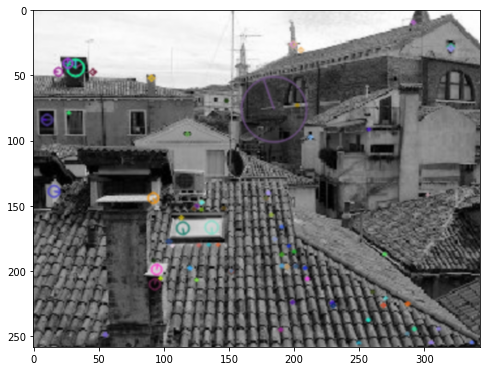

In [45]:
img_desc = cv2.drawKeypoints(gray, kps, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
imshow(img_desc)

In [48]:
def filter_ransac(kps):
    X = np.array([kp.pt[0] for kp in kps]).reshape(-1, 1)
    y = np.array([kp.pt[1] for kp in kps])
    
    ransac = RANSACRegressor(residual_threshold=5, random_state=1337)
    ransac.fit(X, y)

    return np.array(kps)[ransac.inlier_mask_]

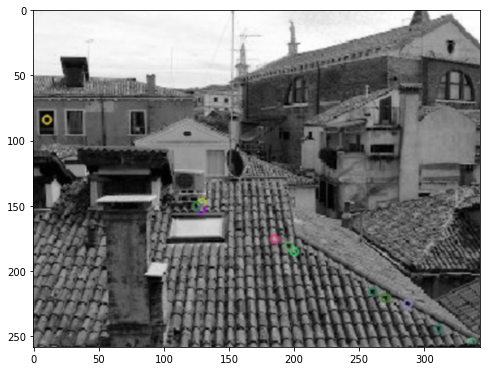

In [50]:
new_kps = filter_ransac(kps)
img_desc = cv2.drawKeypoints(gray, new_kps, None)
imshow(img_desc)